In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import keras
import keras_tuner as kt


# Load Data

In [2]:
# Generate data paths with labels
data_dir = 'Data/Weather_Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Filepath_series = pd.Series(filepaths, name= 'filepaths')
Label_series = pd.Series(labels, name='labels')
df = pd.concat([Filepath_series, Label_series], axis= 1)

df.head()


filepaths     labels
0  Data/Weather_Dataset/lightning/2100.jpg  lightning
1  Data/Weather_Dataset/lightning/2114.jpg  lightning
2  Data/Weather_Dataset/lightning/2128.jpg  lightning
3  Data/Weather_Dataset/lightning/1838.jpg  lightning
4  Data/Weather_Dataset/lightning/1964.jpg  lightning

# Delete corrupted image paths

In [3]:
num_skipped = 0
for folder_name in ('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow'):
    folder_path = os.path.join("Data/Weather_Dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


# First 5 Images per Class of Uncleaned Data

{'dew': [5111, 5112, 5113, 5114, 5115], 'fogsmog': [3753, 3754, 3755, 3756, 3757], 'frost': [3294, 3295, 3296, 3297, 3298], 'glaze': [1024, 1025, 1026, 1027, 1028], 'hail': [4550, 4551, 4552, 4553, 4554], 'lightning': [0, 1, 2, 3, 4], 'rain': [1655, 1656, 1657, 1658, 1659], 'rainbow': [5798, 5799, 5800, 5801, 5802], 'rime': [2157, 2158, 2159, 2160, 2161], 'sandstorm': [362, 363, 364, 365, 366], 'snow': [6025, 6026, 6027, 6028, 6029]}


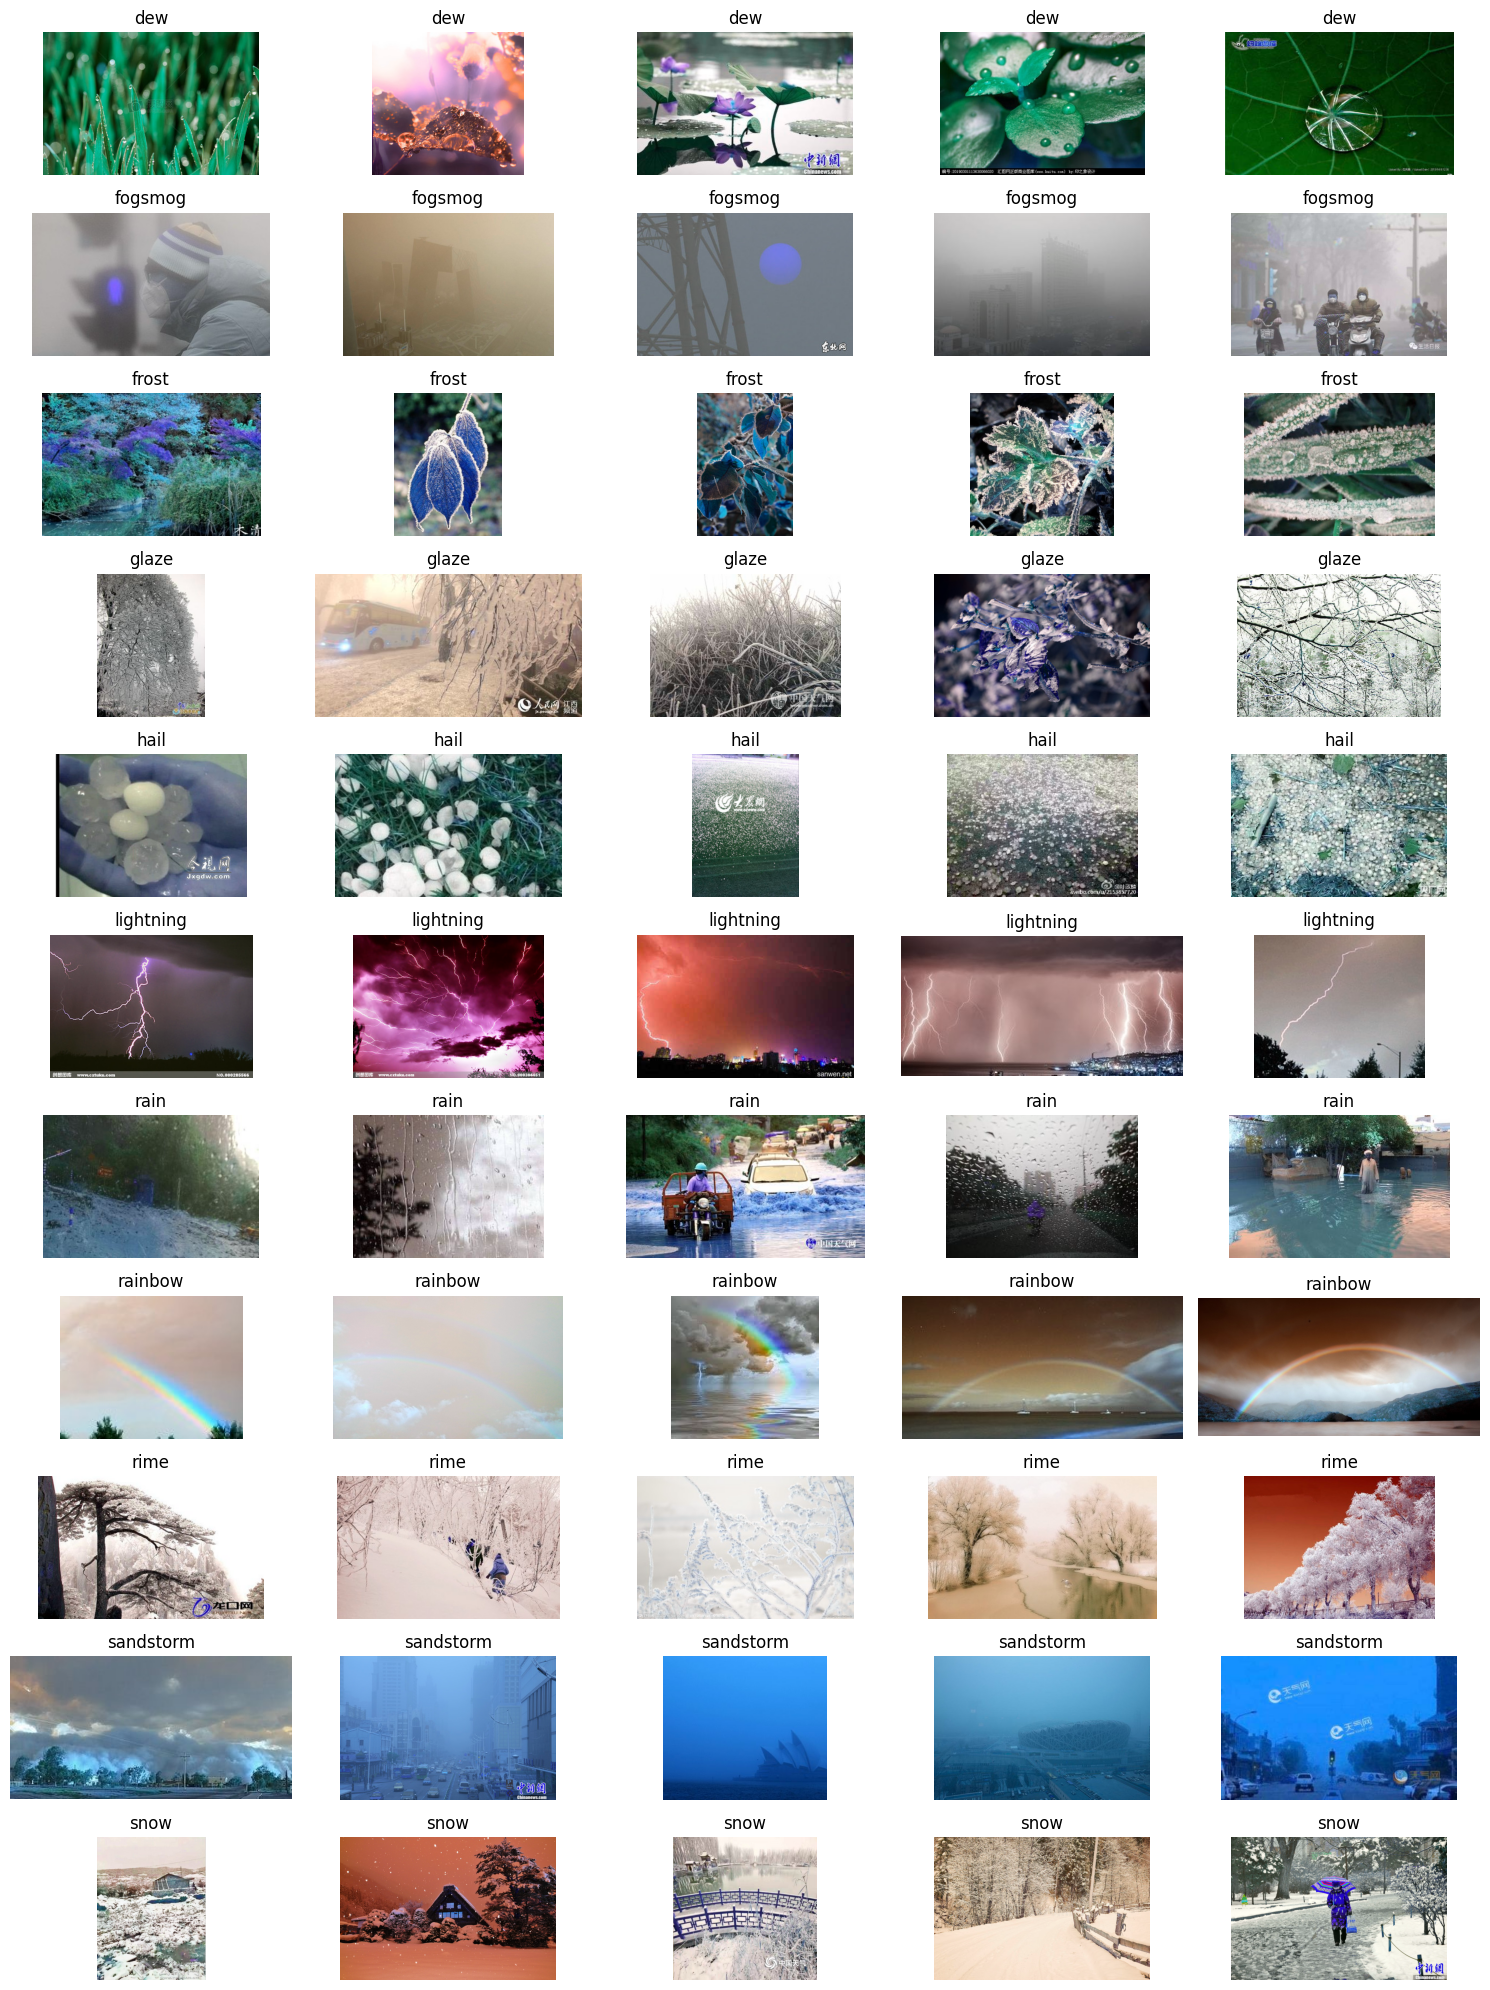

In [4]:
# Exploring first 5 images of each class from X_train
first_5_indeces_per_class = {i: [] for i in ('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow')}
for index, label in enumerate(df['labels']):
    if len(first_5_indeces_per_class[label]) < 5:
        first_5_indeces_per_class[label].append(index)
    if all(len(first_5_indeces_per_class[i]) == 5 for i in ('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow')):
        break

print(first_5_indeces_per_class)

fig, axes = plt.subplots(11, 5, figsize=(15, 20))
for i, label in enumerate(('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow')):
    for j, index in enumerate(first_5_indeces_per_class[label]):
        axes[i, j].imshow(cv2.imread(df['filepaths'][index]))
        axes[i, j].set_title(label)
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

# Convert images to data

In [5]:
dew, fogsmog, frost, glaze, hail, lightning, rain, rainbow, rime, sandstorm, snow = [] ,[], [], [], [], [], [], [], [], [], []
labels = []
def process_images(folder, image_list):
    for image in os.listdir(folder):
        path = os.path.join(folder, image)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, (256, 256))
            image_list.append(img)
            labels.append(folder.split("/")[-1])
        else:
            print(f"Warning: Unable to read image {path}")

folders = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
i = 0
for images in [dew, fogsmog, frost, glaze, hail, lightning, rain, rainbow, rime, sandstorm, snow]:
    process_images(str("Data/Weather_Dataset/" + folders[i]), images)
    i += 1

data = np.concatenate((np.asarray(dew),
                       np.asarray(fogsmog),
                       np.asarray(frost),
                       np.asarray(glaze),
                       np.asarray(hail),
                       np.asarray(lightning),
                       np.asarray(rain),
                       np.asarray(rainbow),
                       np.asarray(rime),
                       np.asarray(sandstorm),
                       np.asarray(snow)
                    ), axis=0)
print(data.shape)
print(len(labels))

(6604, 256, 256, 3)
6604


# Encode Labels

In [6]:
label_data = {'labels': labels}
label_data_df = pd.DataFrame(label_data)
encoder = OneHotEncoder()
encoded_labels = encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()
print(label_data_df.iloc[0], encoded_labels[0], encoder.inverse_transform(encoded_labels[0].reshape(1,-1))[0][0])
encoded_labels

labels    dew
Name: 0, dtype: object [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] dew


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Shuffle Data and Split to Train and Test sets

In [7]:
np.random.seed(1234)
shuffled_indices = np.random.permutation(range(len(data)))
X = data[shuffled_indices]
Y = encoded_labels[shuffled_indices]
print(f"X.shape: {X.shape}")
print(f"Y.shape: {Y.shape}")


X.shape: (6604, 256, 256, 3)
Y.shape: (6604, 11)


In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.4, random_state=1234)
X_test, X_val, Y_test, Y_val = train_test_split(X_val, Y_val, test_size=0.5, random_state=1234)

# Part 2, print the shape of each
print(f"X_train.shape: {X_train.shape}\tY_train.shape: {Y_train.shape}")
print(f"X_val.shape: {X_val.shape}\tY_val.shape: {Y_val.shape}")
print(f"X_test.shape: {X_test.shape}\tY_test.shape: {Y_test.shape}")

X_train.shape: (3962, 256, 256, 3)	Y_train.shape: (3962, 11)
X_val.shape: (1321, 256, 256, 3)	Y_val.shape: (1321, 11)
X_test.shape: (1321, 256, 256, 3)	Y_test.shape: (1321, 11)


# Normalize and Scale Images

In [9]:
# check max and min pixel values
print(np.max(X_train), np.min(X_train))

255 0


In [10]:
scaler = MinMaxScaler() # scale pixel values between 0 and 1
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_train.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_train.shape[-1])).reshape(X_test.shape)

X_train = X_train.reshape(X_train.shape[0], 256,256,3)
X_val = X_val.reshape(X_val.shape[0], 256,256,3)
X_test = X_test.reshape(X_test.shape[0], 256,256,3)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3962, 256, 256, 3)
(1321, 256, 256, 3)
(1321, 256, 256, 3)


# Data Exploration of Training Dataset

       labels  count
0        rime    714
1     fogsmog    476
2   sandstorm    409
3         dew    399
4       glaze    363
5        hail    352
6        snow    338
7        rain    306
8       frost    259
9   lightning    198
10    rainbow    148


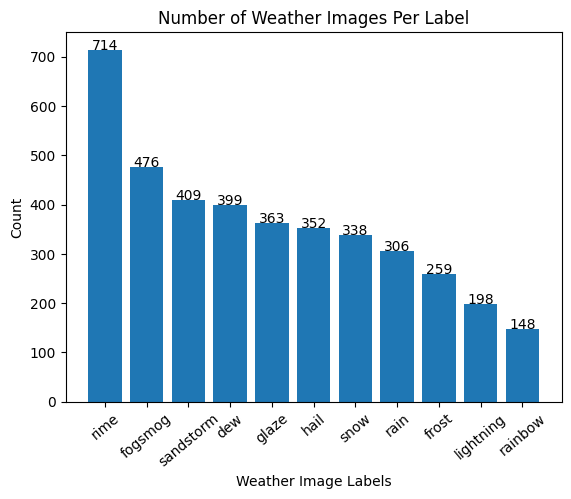

In [11]:
# Number of images per  class
decoded_labels = encoder.inverse_transform(Y_train)

counts = pd.DataFrame(decoded_labels).value_counts().to_frame().reset_index()
counts.columns = ['labels', 'count']
print(counts)

# Plot the distribution of the labels
plt.bar(counts['labels'], counts['count'])
for i in range(len(counts)):
    plt.text(i, counts['count'][i], counts['count'][i], ha = 'center')
plt.title("Number of Weather Images Per Label")
plt.xlabel("Weather Image Labels")
plt.xticks(rotation=40)
plt.ylabel("Count")
plt.show()

{'dew': [1, 7, 16, 25, 59], 'fogsmog': [18, 22, 49, 52, 97], 'frost': [8, 33, 71, 84, 88], 'glaze': [0, 20, 34, 57, 61], 'hail': [6, 10, 12, 15, 28], 'lightning': [9, 27, 126, 141, 143], 'rain': [50, 54, 56, 70, 92], 'rainbow': [21, 32, 38, 46, 120], 'rime': [3, 17, 19, 24, 26], 'sandstorm': [2, 4, 5, 11, 23], 'snow': [13, 14, 41, 47, 53]}


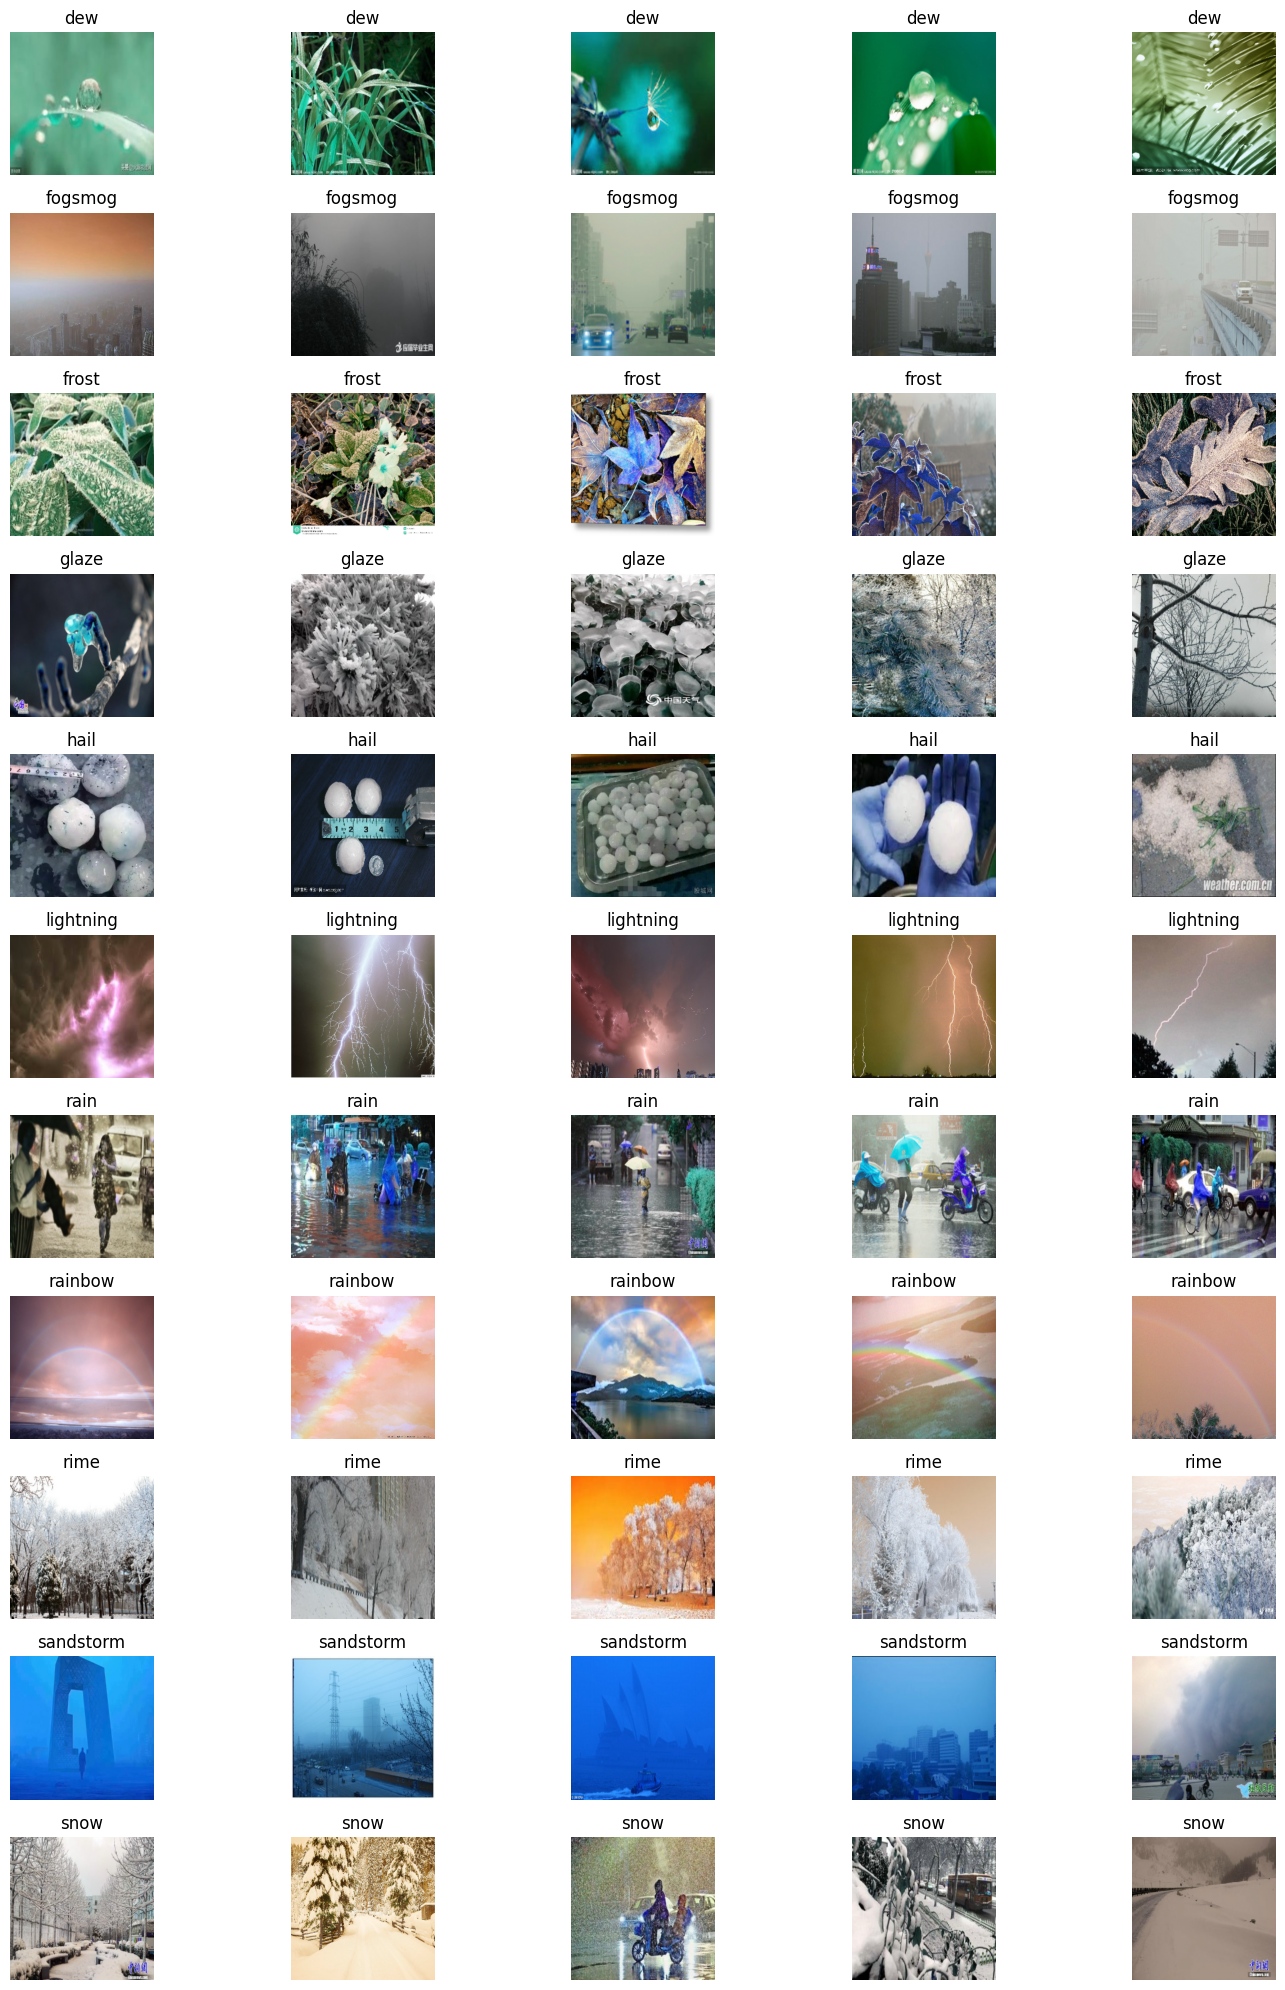

In [12]:
# Exploring first 5 images of each class from shuffled X_train
first_5_indeces_per_class = {i: [] for i in encoder.categories_[0]}
for index, label in enumerate(Y_train):
    label = encoder.inverse_transform(label.reshape(1,-1))[0][0]
    if len(first_5_indeces_per_class[label]) < 5:
        first_5_indeces_per_class[label].append(index)
    if all(len(first_5_indeces_per_class[i]) == 5 for i in encoder.categories_[0]):
        break

print(first_5_indeces_per_class)

fig, axes = plt.subplots(11, 5, figsize=(15, 20))
for i, label in enumerate(encoder.categories_[0]):
    for j, index in enumerate(first_5_indeces_per_class[label]):
        axes[i, j].imshow(X_train[index].reshape(256, 256, 3))
        axes[i, j].set_title(label)
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

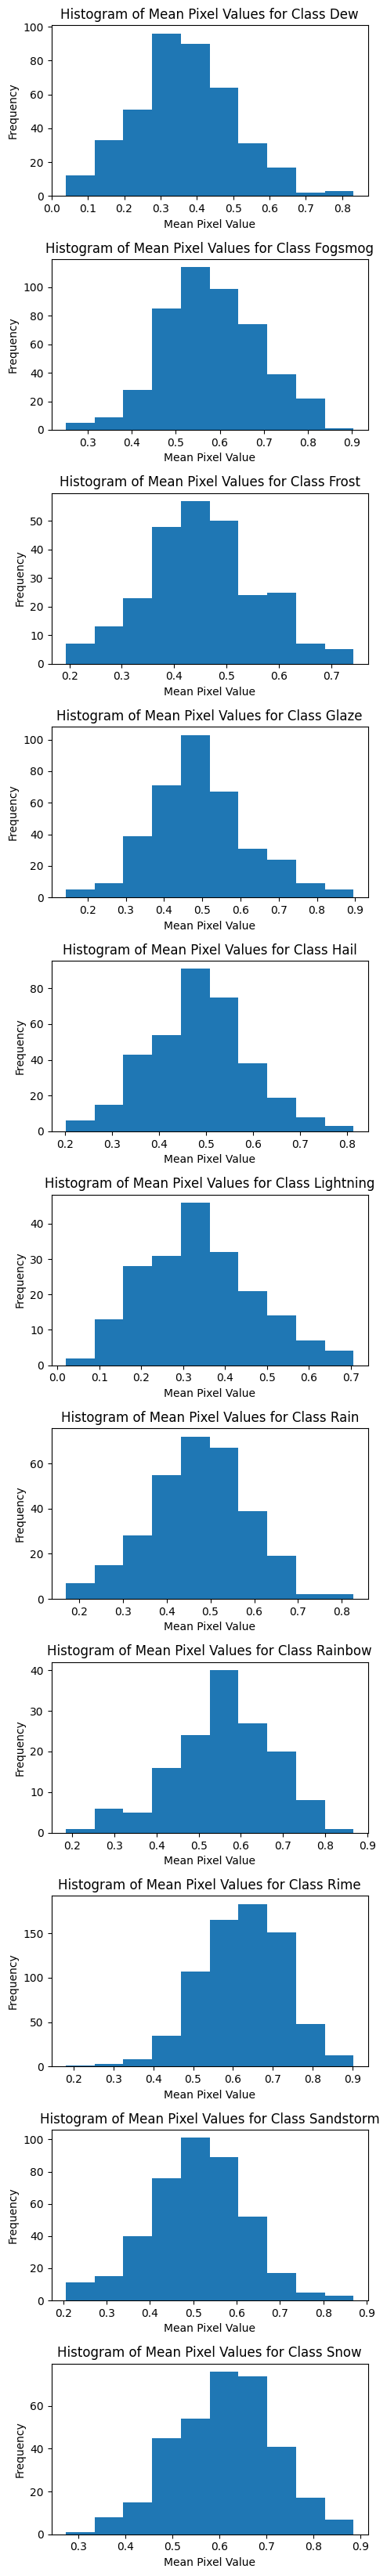

The mean pixel value across all images in class 0 is 0.3676383655104494.
The mean pixel value across all images in class 1 is 0.5796441059800816.
The mean pixel value across all images in class 2 is 0.4542957105773053.
The mean pixel value across all images in class 3 is 0.49498414884935515.
The mean pixel value across all images in class 4 is 0.48531658815190115.
The mean pixel value across all images in class 5 is 0.3387874217192993.
The mean pixel value across all images in class 6 is 0.4730386539354772.
The mean pixel value across all images in class 7 is 0.5572319487635901.
The mean pixel value across all images in class 8 is 0.6244357552846762.
The mean pixel value across all images in class 9 is 0.5101837488362774.
The mean pixel value across all images in class 10 is 0.6111099487474643.


In [22]:
#  Initialize lists to store mean pixel values for each class
mean_pixel_values = [[] for _ in encoder.categories_[0]]

# Calculate mean pixel values for each class
for i in range(len(Y_train)):
    class_label = encoder.inverse_transform(Y_train[i].reshape(1,-1))[0][0]
    for label in range(len(encoder.categories_[0])):
        if class_label == encoder.categories_[0][label]:
            mean_pixel_values[label].append(np.mean(X_train[i]))

# Create subplots
fig, axes = plt.subplots(len(encoder.categories_[0]), 1, figsize=(5, 3 * len(encoder.categories_[0])))

# Plot histograms for each class
for class_label in range(len(encoder.categories_[0])):
    axes[class_label].hist(mean_pixel_values[class_label])
    axes[class_label].set_title(f"Histogram of Mean Pixel Values for Class {encoder.categories_[0][class_label].title()}")
    axes[class_label].set_xlabel("Mean Pixel Value")
    axes[class_label].set_ylabel("Frequency")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Print mean pixel value for each class
for class_label in range(len(encoder.categories_[0])):
    print(f"The mean pixel value across all images in class {class_label} is {np.mean(mean_pixel_values[class_label])}.")

# Baseline Logistic Regression with TensorFlow

In [27]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Part 3, print the shape of X_train and X_test
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3962, 196608)
(1321, 196608)
(1321, 196608)


In [29]:
def build_model(num_features, learning_rate):
  """Build a TF logistic regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=11,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation='softmax',     # softmax activation function for mutliclass classification
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy())  # Categorical cross entropy (multiclass log loss)

  return model

In [48]:
tf.random.set_seed(1234)
# Build and compile model
model_tf = build_model(X_train.shape[1], learning_rate=0.0001)

model_tf_history = model_tf.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_val, Y_val))

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 2.1229 - val_loss: 1.8473
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.7513 - val_loss: 1.7210
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.6422 - val_loss: 1.6639
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.5853 - val_loss: 1.6310
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.5481 - val_loss: 1.6089


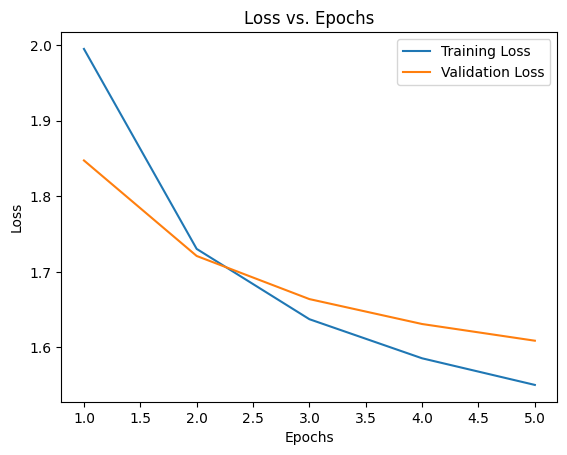

In [49]:
training_loss = model_tf_history.history['loss']
validation_loss = model_tf_history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Evaluate the Model

In [93]:
train_loss = model_tf.evaluate(X_train, Y_train)
val_loss = model_tf.evaluate(X_val, Y_val)

print(f"Training loss: {train_loss}")
print(f"Validation loss: {val_loss}")

124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.5217
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5906
Training loss: 1.5324150323867798
Validation loss: 1.6089081764221191


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1321 1321


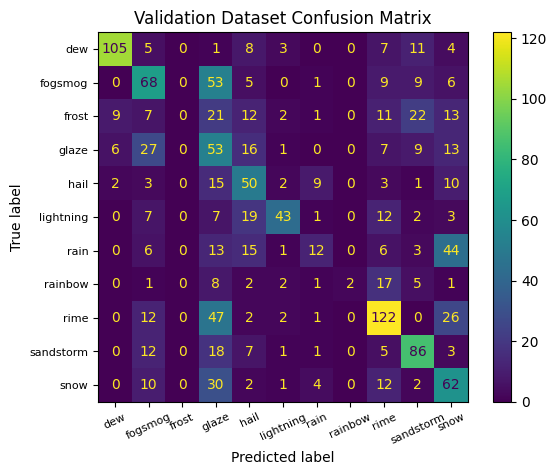

Len of X_val: 1321


In [89]:
Y_val_pred = model_tf.predict(x=X_val)
Y_val_labels = np.argmax(Y_val, axis=1)
# Get the class with the highest probability for each sample
Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)
print(len(Y_val_labels), len(Y_val_pred_classes))
conf_matrix=confusion_matrix(Y_val_labels, Y_val_pred_classes)
# Plot confusion matrix
plot_labels = [f"{encoder.categories_[0][i]}" for i in range(11)]
display = ConfusionMatrixDisplay(conf_matrix, display_labels=plot_labels)
display.plot()
plt.title("Validation Dataset Confusion Matrix")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8, rotation=25)
plt.show()

# Printing True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN)
print(f"Len of X_val: {len(X_val)}")



# Subgroup Accuracy